<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter07/Understanding_selectivesearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Selective Search

In [1]:
# !pip install selectivesearch
# !pip install torch_snippets
from torch_snippets import *
import selectivesearch
from skimage.segmentation import felzenszwalb

In [3]:
# !wget https://www.dropbox.com/s/l98leemr7r5stnm/Hemanvi.jpeg
img = read('Hemanvi.jpeg', 1)

Extract the `felzenszwalb` segments (which are obtained based on the color, texture, size, and shape compatibility of content within an image)
from the image:

In [4]:
segments_fz = felzenszwalb(img, scale=200)

Note that in the felzenszwalb method, scale represents the number of clusters that can be formed within the segments of the image. The higher the value of scale, the greater the detail of the original image that is preserved

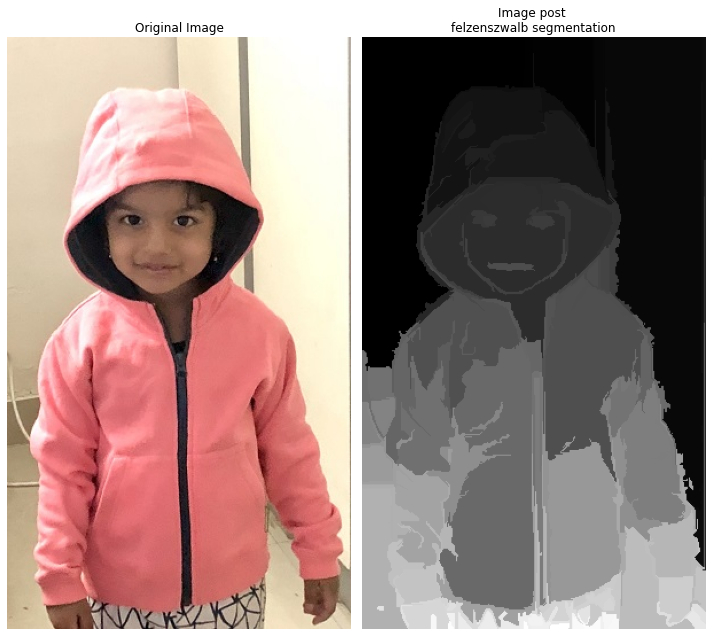

In [5]:
subplots([img, segments_fz], titles=['Original Image','Image post \nfelzenszwalb segmentation'], figsize=(10,10), nc=2)

From the preceding output, note that pixels that belong to the same group have similar pixel values  

Pixels that have similar values form a region proposal. This now helps in object detection, as we now pass each region proposal to a network and ask it to predict whether the region proposal is a background or an object. Furthermore, if it is an object, it would help us to identify the offset to fetch the tight bounding box corresponding to the object and also the class corresponding to the content within the region proposal.

In [6]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates


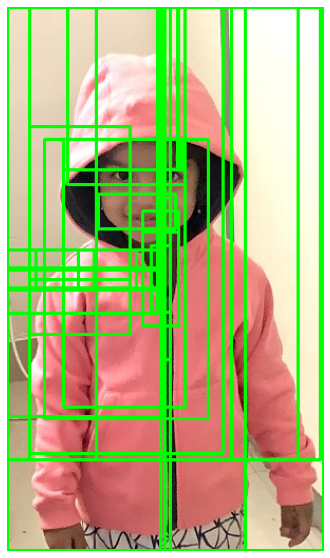

In [7]:
candidates = extract_candidates(img)
show(img, bbs = candidates)

How do we leverage region proposals for object detection and localization?  
A region proposal that has a high intersection with the location (ground truth) of an object in the image of interest is labeled as the one that contains the object, and a region proposal with a low intersection is labeled as background.

# Understanding IoU

*Intersection* within the term *Intersection over Union* measures how overlapping the predicted and actual bounding boxes are, while *Union* measures the overall space possible for overlap. IoU is the ratio of the overlapping region between the two
bounding boxes over the combined region of both the bounding boxes  

This can be represented in a diagram as follows:
![IOU](IOU.png)  


In the following diagram, you can observe the variation in the IoU metric as the overlap between bounding boxes varies:  
![iou_scores](iou_scores.png)

and now lets implement the function that calculates the IoU:

In [ ]:
def get_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

next, we will learn about non-max suppression, which helps in shortlisting from the different possible predicted bounding boxes
around an object when inferring using the trained model on a new image.

# Non-max Suppression

**Non-max** refers to the boxes that do not contain the highest probability of containing an object, and **suppression** refers to us discarding those boxes that do not contain the highest probabilities of containing an object. 

In non-max suppression, we identify the bounding box that has the highest probability and discard all the other bounding
boxes that have an IoU greater than a certain threshold with the box containing the highest probability of containing an object.  

In PyTorch, non-max suppression is performed using the `nms` function in the `torchvision.ops` module. The `nms` function takes the bounding box coordinates, the confidence of the object in the bounding box, and the threshold of IoU across bounding boxes, to identify the bounding boxes to be retained. You will be leveraging the `nms` function when predicting object classes and bounding boxes of objects in a new image in both the Training R-CNN-based custom object detectors and Training Fast R-CNN-based custom object detectors sections in steps 19 and 16, respectively.

# Mean Average Precision
How do we quantify the accuracy of the predictions coming from our model? mAP !  

Before we try to understand mAP, let's first understand precision, then average precision, and finally, mAP

- **Precision**: Typically calculated as $Precision = \frac{\text{True positives}}{(\text{True positives + False positives})}$  

A true positive refers to the bounding boxes that predicted the correct class
of objects and that have an IoU with the ground truth that is greater than a
certain threshold. A false positive refers to the bounding boxes that
predicted the class incorrectly or have an overlap that is less than the
defined threshold with the ground truth. Furthermore, if there are multiple
bounding boxes that are identified for the same ground truth bounding box,
only one box can get into a true positive, and everything else gets into a
false positive.

- **Average Precision**: Average precision is the average of precision values calculated at various IoU thresholds
- **mAP**: mAP is the average of precision values calculated at various IoU threshold values across all the classes of objects present within the dataset.